# VK API Analytics

Task: **Create Analytics report for marketing department of the company**  
Object of Analysis:  [VK page](https://vk.com/skillbox_education)
  
In the Analysis, we will make requests to get info about posts in web-page for specific period.  
We will analyse the influence of different factors (time of publication) on users activity (like and comments)

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

def get_date(date):
    dt = (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')
    return dt

def get_response(vk_token, offset, count, owner_id):
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + \
     '&owner_id=' + str(owner_id) + '&offset=' + str(offset) + \
     '&count=' + str(count) + '&v=5.92'
    response = getjson(url)
    return response

def get_df_from_response(response, offset):
    post_datetime_str = get_date(response['response']['items'][0]['date'])
    post_datetime = datetime.strptime(post_datetime_str, '%Y-%m-%d %H:%M:%S')
    post_date = post_datetime.date()
    post_time = post_datetime.time()
    text = response['response']['items'][0]['text']
    comments_amount = response['response']['items'][0]['comments']['count']
    likes_amount = response['response']['items'][0]['likes']['count']
    df = pd.DataFrame({
        'post_id': [offset],
        'post_datetime' : [post_datetime],
        'post_date': [post_date],
        'post_time': [post_time],
        'text': [text],
        'comments_amount': [comments_amount],
        'likes_amount': [likes_amount]
    })
    return df

Period of analysis:  
- Date start: We will consider posts starting 2021-11-19
- Date end: 2022-01-19 (2 months)  
the period should not be very long, since development of web-page can significantly infuence users activity (new posts may have higher or lower activity due to new features implemented etc.)

In [48]:
import os
from dotenv import load_dotenv
load_dotenv()
vk_token = os.getenv('MY_ACCESS_TOKEN')
offset_start = 260
offset_end = 178
count = 1
owner_id = -66669811

# start:
response_start = get_response(vk_token=vk_token, offset = offset_start, count=count, owner_id=owner_id)
df_start = get_df_from_response(response_start, offset_start)

#end:
response_end = get_response(vk_token=vk_token, offset = offset_end, count=count, owner_id=owner_id)
df_end = get_df_from_response(response_end, offset_end)

In [49]:
df_start

,post_id,post_datetime,post_date,post_time,text,comments_amount,likes_amount
0,260,2021-11-19 02:04:53,2021-11-19,02:04:53,С удовольствием смотрите фильмы вроде «Банды Н...,0,19


In [50]:
df_end

,post_id,post_datetime,post_date,post_time,text,comments_amount,likes_amount
0,178,2022-01-19 02:08:39,2022-01-19,02:08:39,"К сожалению, мы (и вы, уверены, тоже) часто ст...",6,27


We will get data by iterating offset in dates, each interation will be one row in result table

In [53]:
df_final = df_start.drop(axis=0, index=0) # shape of final df
for offset in range(offset_end, offset_start):
    response_iter = get_response(vk_token=vk_token, offset = offset, count=count, owner_id=owner_id)
    df_iter = get_df_from_response(response_iter, offset)
    df_final = pd.concat([df_final, df_iter], ignore_index=True)
print('fine')


fine


In [55]:
df_final.head(2)

,post_id,post_datetime,post_date,post_time,text,comments_amount,likes_amount
0,178,2022-01-19 02:08:39,2022-01-19,02:08:39,"К сожалению, мы (и вы, уверены, тоже) часто ст...",6,27
1,179,2022-01-18 18:09:17,2022-01-18,18:09:17,"Замечали когда-нибудь, как мотивируют чужие ус...",2,225


For analysis, we will divide 24 hours period on 4 periods:
- 07:00 - 13:00 - first part of the day
- 13:00 - 19:00 - second part of the day
- 19:00 - 01:00 - evening/beggining of the night
- 01:00 - 07:00 - night/early morning

Then categorise posts in different time periods:

In [56]:
time_1 = datetime(2000,1,1,7,0,0).time() # 07:00
time_2 = datetime(2000,1,1,13,0,0).time() # 13:00
time_3 = datetime(2000,1,1,19,0,0).time() # 19:00
time_4 = datetime(2000,1,1,1,0,0).time() # 01:00

period_colors = {
    '07:00-13:00' : 'green',
    '13:00-19:00' : 'blue',
    '19:00-01:00' : 'red',
    '01:00-07:00' : 'orange'
}

In [57]:
def determine_time_period(post_time):
    if post_time > time_1 and post_time < time_2:
        post_period = '07:00-13:00'
    elif post_time > time_2 and post_time < time_3:
        post_period = '13:00-19:00'
    elif post_time > time_3 or post_time < time_4:
        post_period = '19:00-01:00'
    elif post_time > time_4 and post_time < time_1:
        post_period = '01:00-07:00'
    else:
        post_period = 'What?!'
    return post_period

In [58]:
df_final['post_period'] = df_final['post_time'].apply(lambda x: determine_time_period(x))

In [59]:
df_final.head(2)

,post_id,post_datetime,post_date,post_time,text,comments_amount,likes_amount,post_period
0,178,2022-01-19 02:08:39,2022-01-19,02:08:39,"К сожалению, мы (и вы, уверены, тоже) часто ст...",6,27,01:00-07:00
1,179,2022-01-18 18:09:17,2022-01-18,18:09:17,"Замечали когда-нибудь, как мотивируют чужие ус...",2,225,13:00-19:00


In [60]:
df_analysis = df_final.groupby(['post_period'], as_index=False).agg({
    'likes_amount': sum # sum of likes
})
df_analysis = df_analysis.sort_values(by='likes_amount')

In [61]:
df_analysis

,post_period,likes_amount
0,01:00-07:00,183
2,19:00-01:00,2189
1,13:00-19:00,3211


<AxesSubplot:xlabel='post_period', ylabel='likes_amount'>

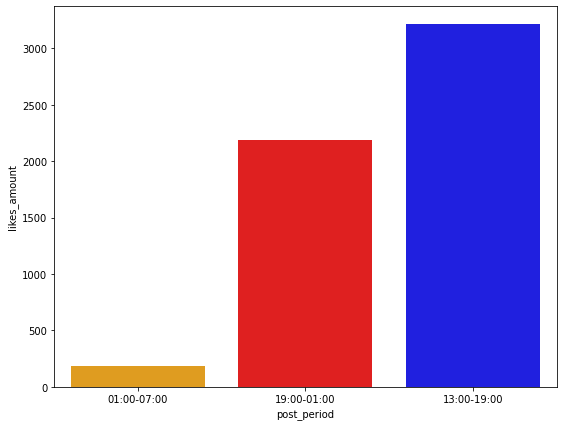

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,7))

sns.barplot(x='post_period', y='likes_amount', data=df_analysis, ax=ax, palette=period_colors)

We can observe:
- posts in the studied period were not published in period 07:00 - 13:00
- the highest amount of user's likes were gain by the posts uploaded in 13:00-19:00 period
- lowest amount of likes in posts uploaded in 01:00-07:00 period

Here it is important to note that number of posts can be different, which may significantly influence final results. Therefore, more correct analysis should be based on Average or Median values:

In [63]:
df_analysis = df_final.groupby(['post_period'], as_index=False).agg({
    'likes_amount': 'mean' # sum of likes
})
df_analysis = df_analysis.sort_values(by='likes_amount')


In [64]:
df_analysis

,post_period,likes_amount
0,01:00-07:00,30.500000
2,19:00-01:00,52.119048
1,13:00-19:00,94.441176


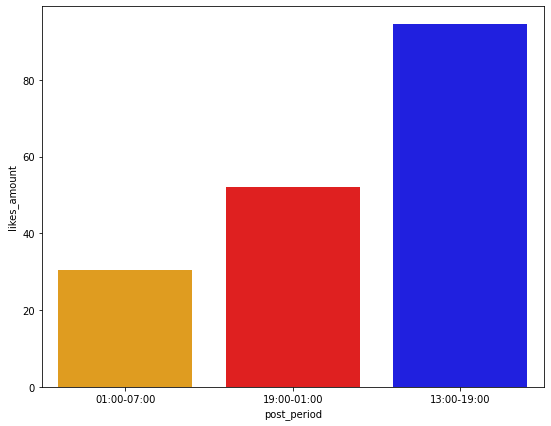

In [65]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,7))

sns.barplot(x='post_period', y='likes_amount', data=df_analysis, ax=ax, palette=period_colors)

ax.tick_params(axis='x')

Relation between periods considering average amount of user's reaction is different, but the overall picture is still as in the total number of reaction analysis

Consider the similar analysis for comments:

In [66]:
df_comm = df_final.groupby(['post_period'], as_index=False).agg({
    'comments_amount': sum
})
df_comm = df_comm.sort_values(by='comments_amount')

In [67]:
df_comm

,post_period,comments_amount
0,01:00-07:00,29
1,13:00-19:00,164
2,19:00-01:00,175


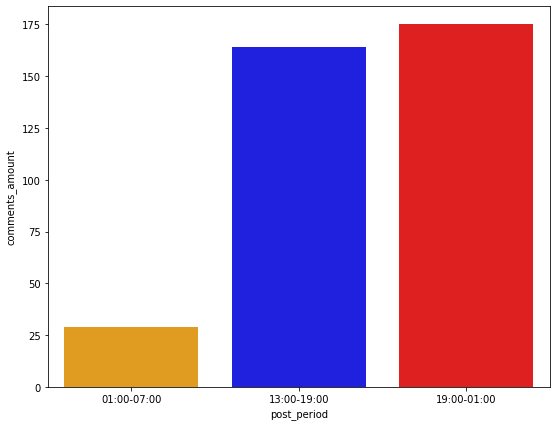

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,7))

sns.barplot(x='post_period', y='comments_amount', data=df_comm, ax=ax, palette=period_colors)

ax.tick_params(axis='x')

Considering comments, we can see slightly different results:
- Leader in amount of comments is period 19:00-01:00
- Lowest number of comments were observed in period 01:00-07:00 (same as in Likes analysis)

Consider Average number of comments:

In [69]:
df_comm = df_final.groupby(['post_period'], as_index=False).agg({
    'comments_amount': 'mean'
})
df_comm = df_comm.sort_values(by='comments_amount')

In [70]:
df_comm

,post_period,comments_amount
2,19:00-01:00,4.166667
1,13:00-19:00,4.823529
0,01:00-07:00,4.833333


<AxesSubplot:xlabel='post_period', ylabel='comments_amount'>

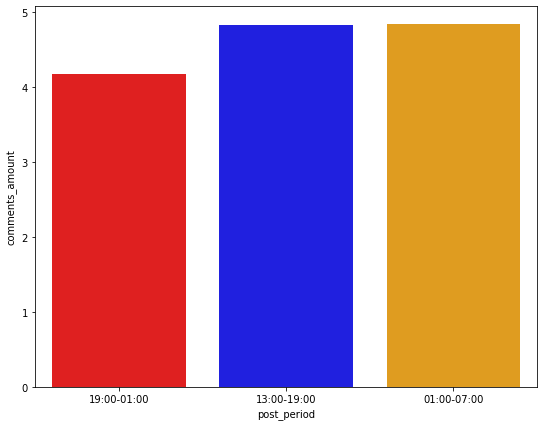

In [71]:
fig, ax = plt.subplots(figsize=(9,7))

sns.barplot(x='post_period', y='comments_amount', data=df_comm, ax=ax, palette=period_colors)

Picture significantly changed:
- Average number of comments is close to each other on all considered periods
- Interesting observation is that Leader in average number of comments is period 01:00-07:00, although this interval was outsider in previous studies

#### *Categories of Posts by '#'*  
For analysis of user's reactions based on posts category following categories were considered:  
this is public not in English, however we still can find the important insights
1) психология (psychology)
2) мультимедиа (multimedia)
3) дизайн (design)
4) маркетинг (marketing)
5) трудоустройство (employment)
6) программирование (programming)
7) игры (games)
8) управление (management)
9) бизнес (business)

In [81]:
import regex as re
def determine_tag(text):
    match_1 = re.search(r'_психология', text, re.IGNORECASE)
    match_2 = re.search(r'_мультимедиа', text, re.IGNORECASE)
    match_3 = re.search(r'_дизайн', text, re.IGNORECASE)
    match_4 = re.search(r'_маркетинг', text, re.IGNORECASE)
    match_5 = re.search(r'_трудоустройство', text, re.IGNORECASE)
    match_6 = re.search(r'_программирование', text, re.IGNORECASE)
    match_7 = re.search(r'_игры', text, re.IGNORECASE)
    match_8 = re.search(r'_управление', text, re.IGNORECASE)
    match_9 = re.search(r'_бизнес', text, re.IGNORECASE)

    if match_1 != None:
        post_tag = 'psychology'
    elif match_2 != None:
        post_tag = 'multimedia'
    elif match_3 != None:
        post_tag = 'design'
    elif match_4 != None:
        post_tag = 'marketing'
    elif match_5 != None:
        post_tag = 'employment'
    elif match_6 != None:
        post_tag = 'programming'
    elif match_7 != None:
        post_tag = 'games'
    elif match_8 != None:
        post_tag = 'management'
    elif match_9 != None:
        post_tag = 'business'
    else:
        post_tag = 'No tag'

    return post_tag

In [82]:
# apply function to determine tags:
df_final['post_tag'] = df_final['text'].apply(lambda x: determine_tag(x))

In [83]:
df_final.tail(2)

,post_id,post_datetime,post_date,post_time,text,comments_amount,likes_amount,post_period,post_tag
80,258,2021-11-19 23:21:33,2021-11-19,23:21:33,"Знакомы с Наполеоном? Нет, мы не про французск...",0,18,19:00-01:00,No tag
81,259,2021-11-19 18:30:39,2021-11-19,18:30:39,"Славянская мифология, русская культура, советс...",5,47,13:00-19:00,design


Consider similart results on amount of likes and comments and average valuesПроведем исследование по среднему количеству лайков и комментариев

Likes:

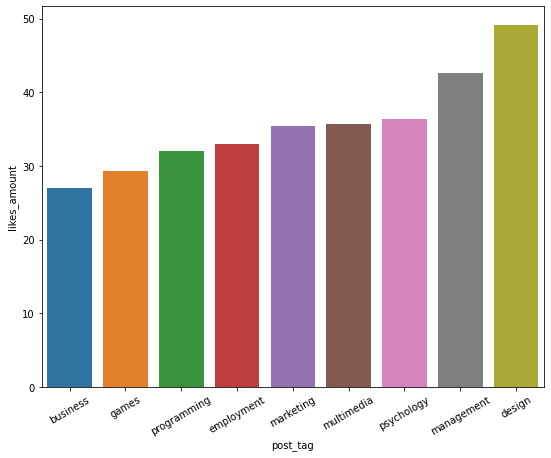

In [84]:
# groupping and calculating mean:
df_likes = df_final.groupby(['post_tag'], as_index=False).agg({
    'likes_amount': 'mean'
})
df_likes = df_likes.sort_values(by='likes_amount')
df_likes = df_likes[df_likes['post_tag'] != 'No tag']

#visualize:
fig, ax = plt.subplots(figsize=(9,7))
sns.barplot(x='post_tag', y='likes_amount', data=df_likes, ax=ax)
ax.tick_params(axis='x', rotation=30)

Outputs:
- highest likes amount in posts with Tag Design
- loset in Business category

Comments:

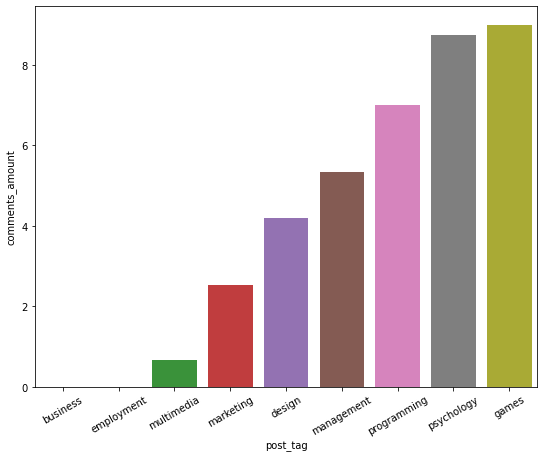

In [85]:
# groupping and calculating mean:
df_comm = df_final.groupby(['post_tag'], as_index=False).agg({
    'comments_amount': 'mean'
})
df_comm = df_comm.sort_values(by='comments_amount')
df_comm = df_comm[df_comm['post_tag'] != 'No tag']

#visualize:
fig, ax = plt.subplots(figsize=(9,7))
sns.barplot(x='post_tag', y='comments_amount', data=df_comm, ax=ax)
ax.tick_params(axis='x', rotation=30)

Outputs:
- Average number of comments is much lower then number of likes
- There is high deviation between categories
- Leaders in the amount of comments is Game category
- In Business and Employment categories were no comments in the considered period